In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [2]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-lul8irg1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-lul8irg1
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=d773db9d700b9cad142da02fdc4503360e52e96063862fb1bacdd66f36231d6d
  Stored in directory: /tmp/pip-ephem-wheel-cache-l1erqelf/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [3]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [4]:
import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [6]:
IMAGE_PATH = '/content/sample.png'

IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget


BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
print(widget.bboxes)
b = widget.bboxes[0]
x = b['x']
y = b['y']
w = b['width']
h = b['height']

[{'x': 36, 'y': 134, 'width': 123, 'height': 126, 'label': ''}]


In [ ]:
position = "center"
if (x < 64 and y < 76):
  position = "Top Left"
elif (x < 64 and y > 76):
  position = "Bottom Left"
elif (x > 64 and y > 76):
  position = "Bottom right"
else:
  position = "Top right"
# x > 80 and y > 127)
val =  position


In [ ]:
print(x)
print(y)
print(w)
print(h)

36
134
123
126


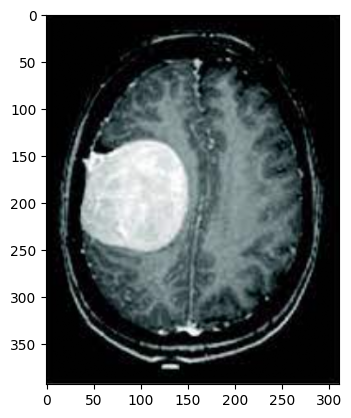

In [ ]:
from skimage import img_as_float
from skimage.metrics import peak_signal_noise_ratio
from matplotlib import pyplot as plt
from skimage import io
from scipy import ndimage as nd
from google.colab.patches import cv2_imshow

noisy_img = img_as_float(io.imread("/content/sample.png"))
plt.imshow(noisy_img, cmap='gray')

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [ ]:
import cv2
import numpy as np
import supervision as sv

mask_predictor = SamPredictor(sam)

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

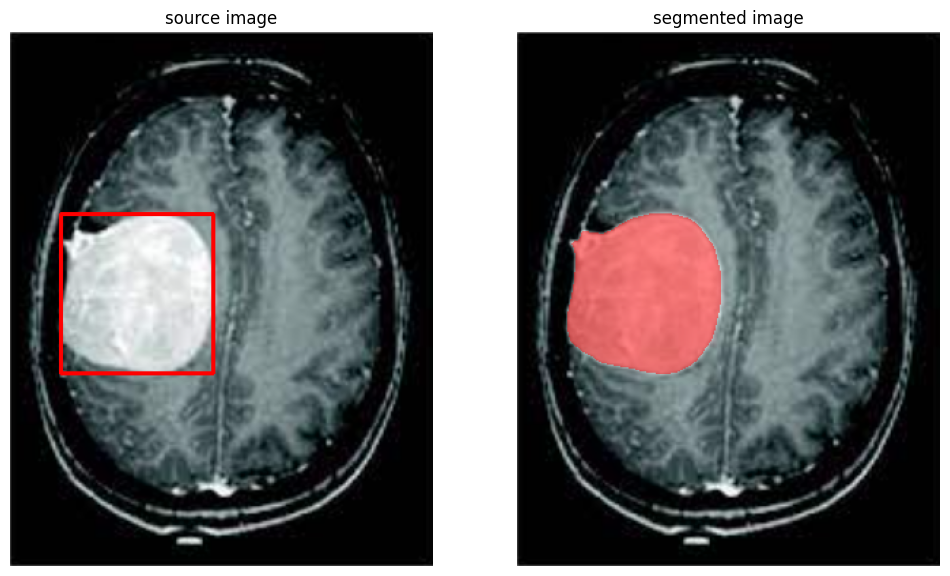

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup='INDEX')

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.min(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)


In [ ]:
detections
detection_area = detections.area
print("Tumor is segmented at " + val )
print("The tumor is detected at co-ordinate : " + "(" + str(x) + "," + str(y) + ")")
print("The area of the segmented tumor is : " + str(detection_area))

Tumor is segmented at Bottom Left
The tumor is detected at co-ordinate : (36,134)
The area of the segmented tumor is : [10920]
